Receiver Functions from start!

In [1]:
import matplotlib.pyplot as plt
import obspy
from obspy.clients.syngine import Client
from obspy.signal.invsim import cosine_taper
import numpy as np
import matplotlib.pyplot as plt
from obspy.taup import TauPyModel

Here we use the built-in Synthetic waveforms calculated by Axisem (instaseis) in obspy

In [2]:
client = Client()
# Define source (earthquake) parameters
origin_time = obspy.UTCDateTime("2020-01-01T00:00:00")  # Arbitrary time
latitude = 20.0       # Source latitude
longitude = 130.0     # Source longitude
depth_in_km = 200.0   # Source depth
m_rr = -0.177e23          #Arbitrar Seismic moment tensor component
m_tt =2.71e23             # Arbitrar Seismic moment tensor component
m_pp =-2.53e23            # Arbitrar Seismic moment tensor component
m_rt = 0.18e23            # Arbitrar Seismic moment tensor component
m_rp = 0.18e23            # Arbitrar Seismic moment tensor component
m_tp = -0.985e23          # Arbitrar Seismic moment tensor component


# Define receiver (station) parameters
station_latitude = 20.0
station_longitude = 50.0
# calculate receiver epicentral distance
receiver_distance_in_deg = obspy.geodetics.locations2degrees(latitude, longitude, station_latitude, station_longitude)

# Request synthetic waveforms using syngine (Z - vertical, R - radial)
st = client.get_waveforms(model="ak135f_2s", sourcelatitude=latitude, sourcelongitude=longitude, 
                          sourcedepthinmeters=depth_in_km * 1000, sourcemomenttensor=[m_rr, m_tt, m_pp, m_rt, m_rp, m_tp], 
                          origintime=origin_time, receiverlatitude=station_latitude, receiverlongitude=station_longitude, 
                          components="ZNE", units="displacement")
st.write('test.mseed')
st2=st.copy()

In [3]:
##define a deconvolution for RF 
def water_level_deconvolution(r, z, sampling_rate, water_level=0.005):
    """
    Perform water-level deconvolution on two signals (radial and vertical components) with
    consideration of the sampling rate.
    
    Parameters:
    r : ndarray
        Radial component of the waveform.
    z : ndarray
        Vertical component of the waveform.
    sampling_rate : float
        Sampling rate of the waveforms (in Hz).
    water_level : float, optional
        Water-level parameter to stabilize the deconvolution (default: 0.01).
    
    Returns:
    h : ndarray
        Receiver function (time domain).
    """

    # Number of samples
    n_samples = len(r)

    # Fourier Transform of both signals
    R = np.fft.fft(r)
    Z = np.fft.fft(z)

    # Frequency array (accounting for sampling rate)
    freqs = np.fft.fftfreq(n_samples, d=1.0/sampling_rate)

    # Compute the spectral ratio (deconvolution)
    H = np.conj(Z) * R / (np.conj(Z) * Z + water_level)

    # Inverse Fourier Transform to get back to time domain
    h = np.real(np.fft.ifft(H))

    # Adjusting for the sampling rate (optional scaling, if necessary)
    # No explicit scaling here since FFT preserves the same units, but you may need to scale depending on output needs.
    
    return h

Calculate the geographic configurations

In [4]:

##calculate the back azimuth, distance, synthetic arrivals
baz = obspy.geodetics.gps2dist_azimuth(station_latitude, station_longitude, latitude, longitude)[1]
model = TauPyModel(model="ak135")  # Use "ak135" for arrival time calculation
distance_in_deg = obspy.geodetics.locations2degrees(station_latitude, station_longitude, latitude, longitude)
arrivals = model.get_travel_times(source_depth_in_km=depth_in_km, distance_in_degree=distance_in_deg, phase_list=["P", "Pms",'P410s','P660s'])
rays = model.get_ray_paths(depth_in_km, distance_in_deg, phase_list=["P", "Pms",'P410s','P660s'])
p_arrival_time = arrivals[0].time  # P-wave arrival
pms_arrival_time = arrivals[1].time  # Pms arriva
p410_arrival_time = arrivals[2].time  # P410s arriva
p660_arrival_time = arrivals[3].time  # P660s arriva


/tmp/ipykernel_23531/2779040241.py:1: ObsPyDeprecationWarning: The plot() function is deprecated. Please use arrivals.plot_rays()
  rays.plot()


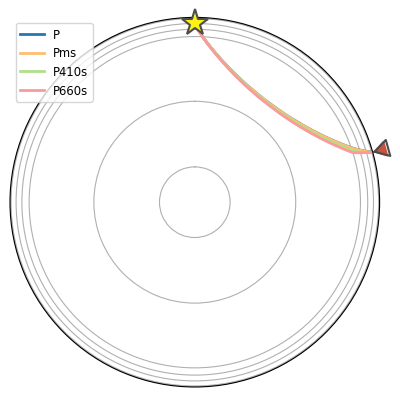

<PolarAxes: >

In [5]:
rays.plot()

Lets process the data

In [6]:


## find the three components from the synthetic stream
st=st2.copy()
stN = st.select(component="N")[0]  # North component
stE = st.select(component="E")[0]  # East component
stZ = st.select(component="Z")[0]  # Vertical component

# Now, rotate the N and E components into Radial and Transverse
stN.stats.component = 'N'
stE.stats.component = 'E'
st.rotate(method="NE->RT", back_azimuth=baz)
# Select Z (Vertical) and R (Radial) components
stZ = st.select(component="Z")[0]  # Vertical component
stR = st.select(component="R")[0]  # Radial component
# Trim waveforms around P-wave arrival
time_window_before = 70  # Time in seconds before P-wave
time_window_after = 200   # Time in seconds after P-wave
start_time = stZ.stats.starttime + p_arrival_time - time_window_before
end_time = stZ.stats.starttime + p_arrival_time + time_window_after

stZ.trim(starttime=start_time, endtime=end_time)
stR.trim(starttime=start_time, endtime=end_time)

# Preprocessing: Detrend, Demean, Taper, and Filter
for tr in [stZ, stR]:
    tr.filter("bandpass", freqmin=0.33, freqmax=1)


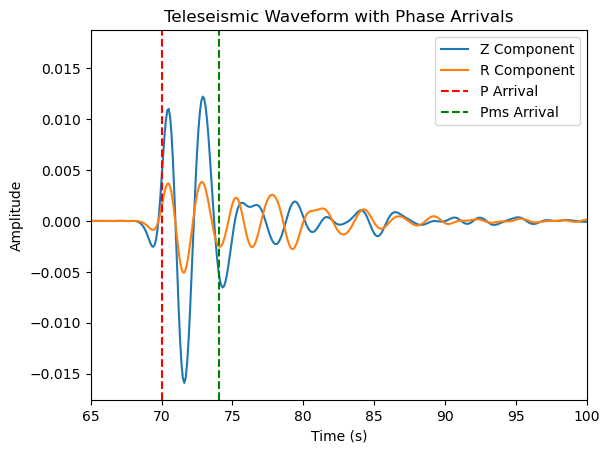

In [7]:
plt.figure()
plt.plot(stZ.times(), stZ.data, label='Z Component')
plt.plot(stR.times(), stR.data, label='R Component')
# Arrival times relative to the waveform start time
p_arrival_time_relative = time_window_before
pms_arrival_time_relative =time_window_before + pms_arrival_time - p_arrival_time

plt.axvline(p_arrival_time_relative, color='r', linestyle='--', label='P Arrival')
plt.axvline(pms_arrival_time_relative, color='g', linestyle='--', label='Pms Arrival')
plt.title("Teleseismic Waveform with Phase Arrivals")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.xlim(time_window_before-5,time_window_before+30)
plt.legend()
plt.show()

In [8]:
# Perform deconvolution to get the receiver function
sampling_rate = stZ.stats.sampling_rate  # Sampling rate in Hz (e.g., 100 Hz)
rf_manual = water_level_deconvolution(stR.data, stZ.data, sampling_rate)
rf_time=stZ.stats.delta*np.linspace(0,len(rf_manual)-1,len(rf_manual))

Good, you have calcualted the receiver functions using the waveforms, maybe we could check the quality of the RF and compare with the velocity model

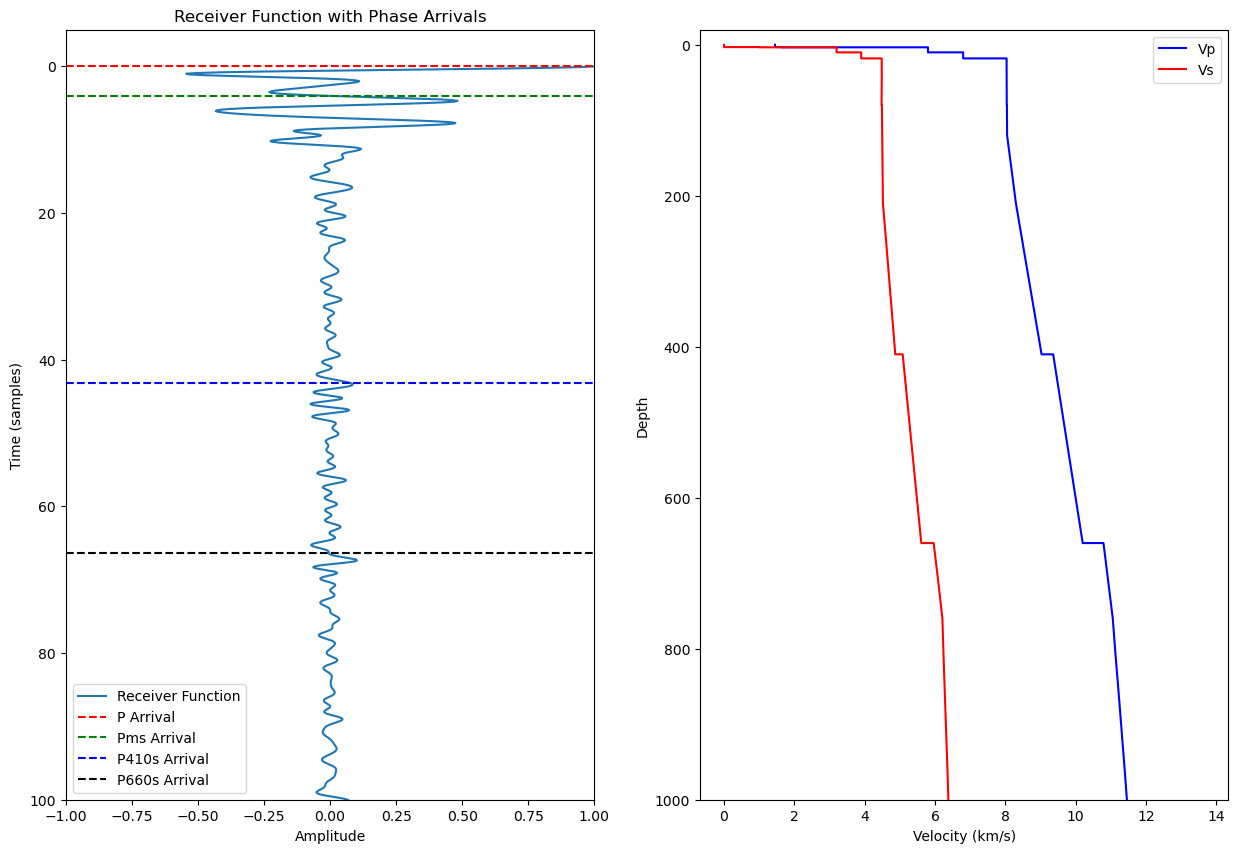

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(rf_manual/rf_manual.max(), rf_time, label='Receiver Function')  # Swap x and y

# Adjust limits for the y-axis (time axis)
plt.ylim(100, -5)
plt.xlim(-1,1)

# Add phase arrival markers
plt.axhline(0, color='r', linestyle='--', label='P Arrival')  # Reference to P arrival time
plt.axhline(pms_arrival_time - p_arrival_time, color='g', linestyle='--', label='Pms Arrival')
plt.axhline(p410_arrival_time - p_arrival_time, color='b', linestyle='--', label='P410s Arrival')
plt.axhline(p660_arrival_time - p_arrival_time, color='k', linestyle='--', label='P660s Arrival')

# Labels and title
plt.title("Receiver Function with Phase Arrivals")
plt.ylabel("Time (samples)")  # Time is now on the y-axis
plt.xlabel("Amplitude")       # Amplitude is now on the x-axis
plt.legend()



plt.subplot(1,2,2)

velocitymodel= np.loadtxt('AK135F_AVG.csv', delimiter=',')
plt.plot(velocitymodel.T[2],velocitymodel.T[0],label='Vp',color='b')
plt.plot(velocitymodel.T[3],velocitymodel.T[0],label='Vs',color='r')
plt.ylim(1000, -20)
plt.ylabel('Depth')
plt.xlabel('Velocity (km/s)')
plt.legend()
# Show the plot
plt.show()


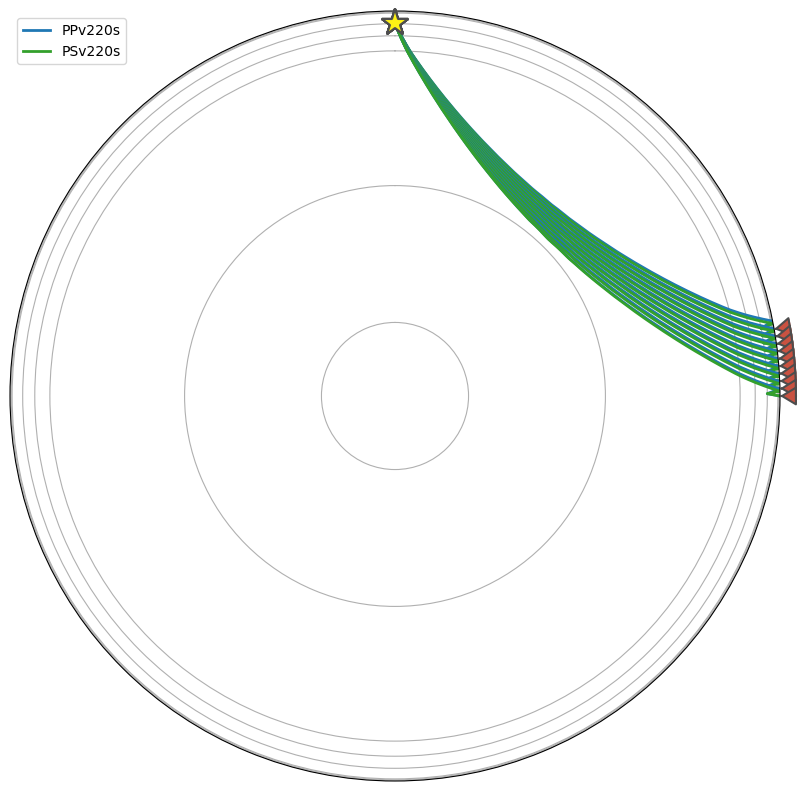

In [11]:
from obspy.taup import plot_ray_paths
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax = plot_ray_paths(source_depth=depth_in_km, ax=ax, fig=fig, legend=True,
                    phase_list=["PPv220s","PSv220s"],min_degrees=80,max_degrees=90)
ax.set_ylim(0, 5)  # Set the radial range from 0 to 5
# Set angular range (in degrees)
ax.set_thetamin(0)   # Set the start angle to 0 degrees
ax.set_thetamax(180) # Set the end angle to 180 degrees
plt.show()

you can see many later arrivals after the Pms,the could be PpPs or PpSs

congrats!you have the basic knowledge of RF calculation. Lets compare it with other RF calculating methods! (https://rf.readthedocs.io/en/latest/)

In [143]:
from rf import read_rf, rfstats
from rf import RFStream

In [144]:
stream =read_rf('test.mseed')

In [145]:

for trace in stream:
    trace.stats.station_latitude=20
    trace.stats.station_longitude=50
    trace.stats.event_latitude=20
    trace.stats.event_longitude=130
    trace.stats.event_depth=200
    trace.stats.event_time=obspy.UTCDateTime("2020-01-01T00:00:00") 
rfstats(stream)

3 Trace(s) in Stream:
XX.S0001.SE.BXZ | -676.1s - 2914.2s onset:2020-01-01T00:11:16.060570Z | 10.0 Hz, 35904 samples | dist:74.4 baz:74.0 slow:5.76
XX.S0001.SE.BXN | -676.1s - 2914.2s onset:2020-01-01T00:11:16.060570Z | 10.0 Hz, 35904 samples | dist:74.4 baz:74.0 slow:5.76
XX.S0001.SE.BXE | -676.1s - 2914.2s onset:2020-01-01T00:11:16.060570Z | 10.0 Hz, 35904 samples | dist:74.4 baz:74.0 slow:5.76

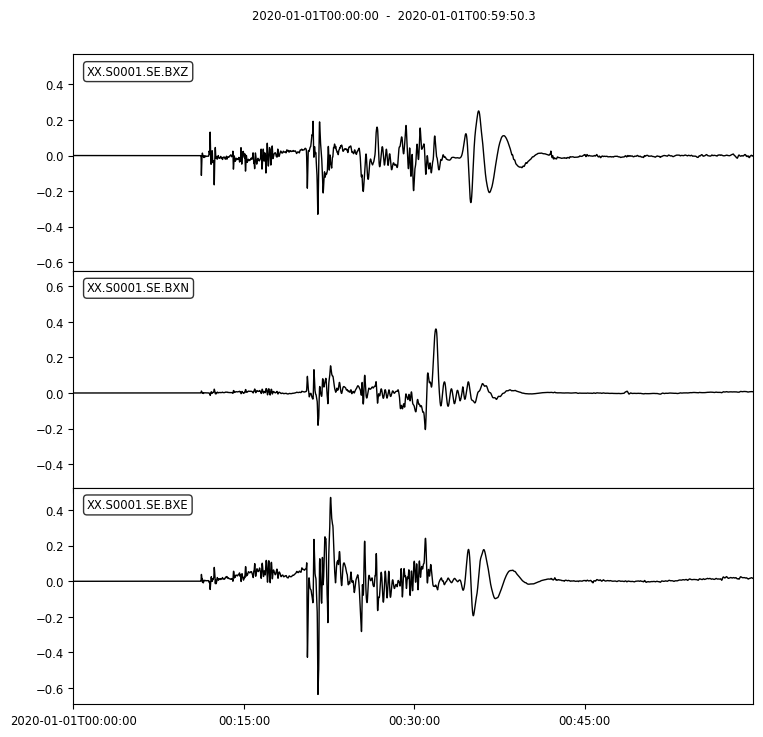

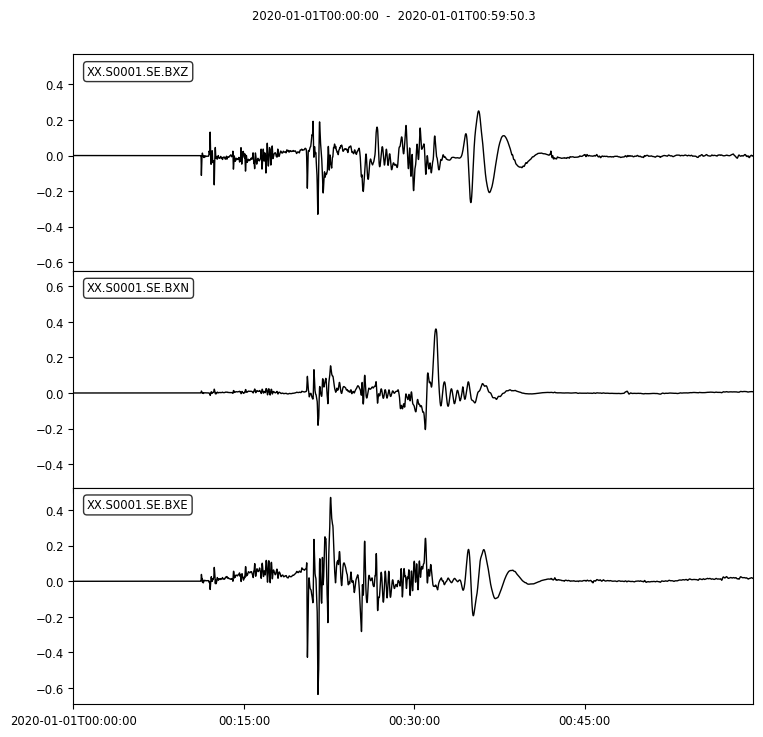

In [146]:
stream.plot()

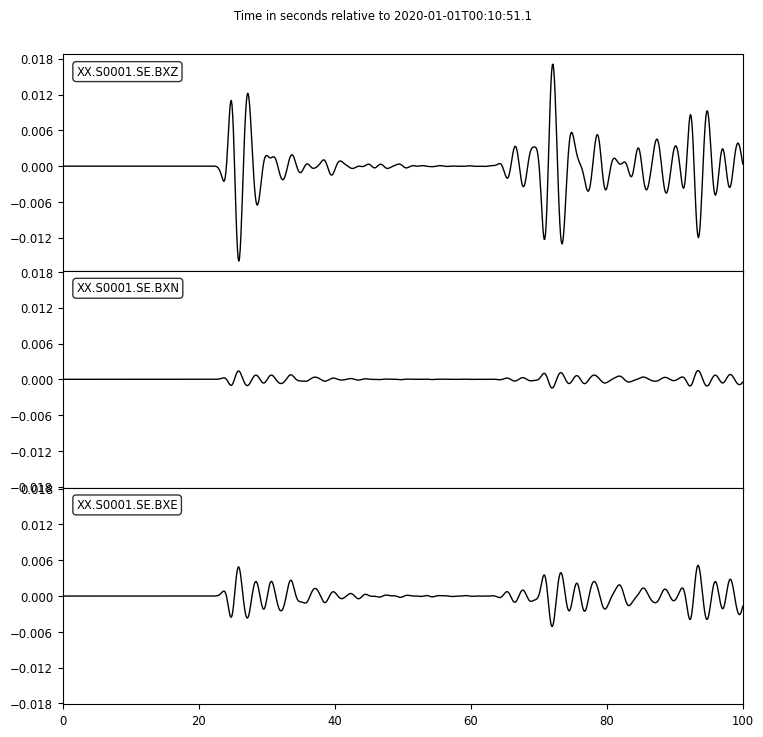

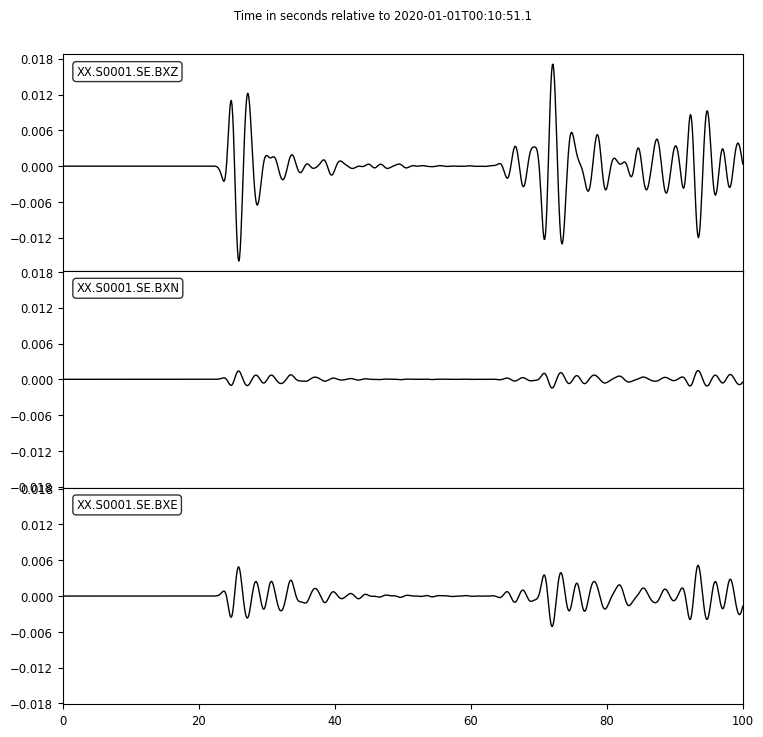

In [147]:
stream.filter('bandpass', freqmin=0.33, freqmax=1)
stream.trim2(-25,75,'onset')
stream[:3].plot(type='relative')

In [152]:
rf_T_domain = stream.copy().rf(deconvolve='time',rotate='NE->RT',solve_toeplitz='scipy').moveout()
rf_F_domain = stream.copy().rf(deconvolve='waterlevel',rotate='NE->RT',waterlevel=0.005).moveout()
rf_iter = stream.copy().rf(deconvolve='iterative',rotate='NE->RT').moveout()
rf_mult = stream.copy().rf(deconvolve='multitaper',rotate='NE->RT').moveout()

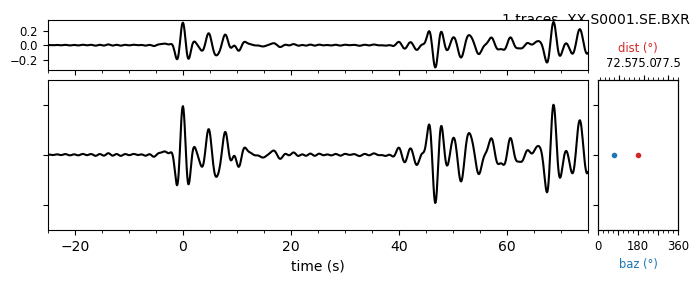

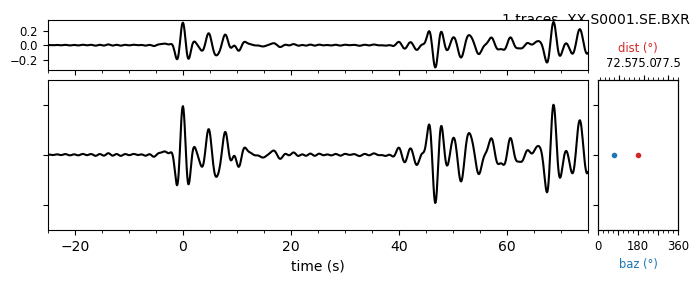

In [153]:
rf_T_domain.select(component='R').plot_rf()

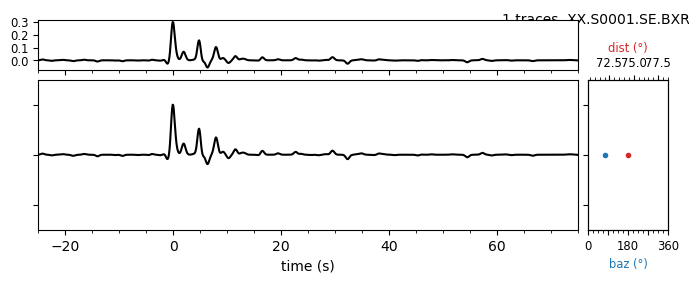

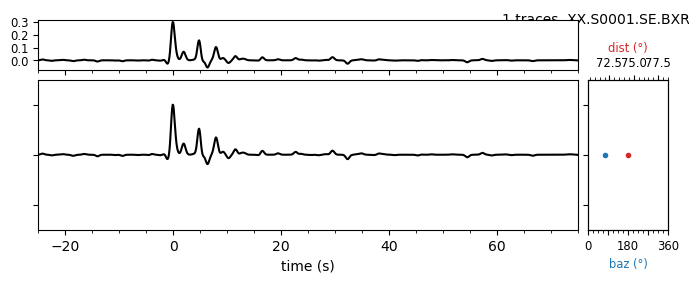

In [154]:
rf_iter.select(component='R').plot_rf()

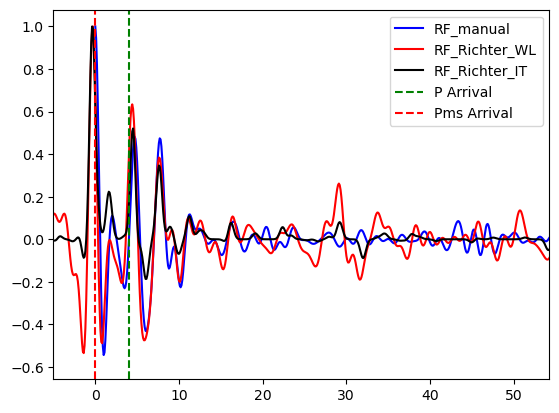

In [157]:
plt.figure()
plt.plot(rf_time,rf_manual/rf_manual.max(), label='RF_manual',color='b')
plt.xlim(-5,30)


rftimeP=rf_F_domain.select(component='R')[0].stats.event_time+p_arrival_time-rf_F_domain.select(component='R')[0].stats.starttime
rftimePs=rf_F_domain.select(component='R')[0].stats.event_time+pms_arrival_time-rf_F_domain.select(component='R')[0].stats.starttime
rf_freq_data=rf_F_domain.select(component='R')[0].data
rf_iter_data=rf_iter.select(component='R')[0].data
plt.plot(rf_F_domain.select(component='R')[0].times()-rftimeP-1,rf_freq_data/rf_freq_data.max(),'r',label='RF_Richter_WL')
plt.plot(rf_iter.select(component='R')[0].times()-rftimeP-1,rf_iter_data/rf_iter_data.max(),'k',label='RF_Richter_IT')


plt.axvline(pms_arrival_time-p_arrival_time, color='g', linestyle='--', label='P Arrival')
plt.axvline(0, color='r', linestyle='--', label='Pms Arrival')
#plt.axvline(0, color='r', linestyle='--', label='Pms Arrival')
#plt.axvline(rftimePs-rftimeP, color='g', linestyle='--', label='Pms Arrival')
plt.xlim(-5,rftimeP+30)
plt.legend()

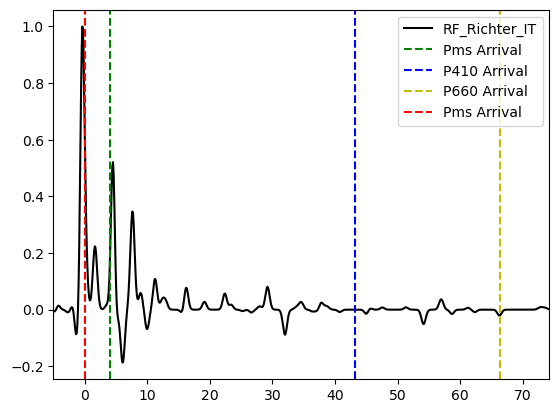

In [178]:
plt.figure()
plt.xlim(-5,30)

rftimeP=rf_F_domain.select(component='R')[0].stats.event_time+p_arrival_time-rf_F_domain.select(component='R')[0].stats.starttime
rftimePs=rf_F_domain.select(component='R')[0].stats.event_time+pms_arrival_time-rf_F_domain.select(component='R')[0].stats.starttime
rf_freq_data=rf_F_domain.select(component='R')[0].data
rf_iter_data=rf_iter.select(component='R')[0].data
rf_T_data=rf_mult.select(component='R')[0].data

#plt.plot(rf_F_domain.select(component='R')[0].times()-rftimeP-1,rf_freq_data/rf_freq_data.max(),'r',label='RF_Richter_WL')
plt.plot(rf_iter.select(component='R')[0].times()-rftimeP-1,rf_iter_data/rf_iter_data.max(),'k',label='RF_Richter_IT')
#plt.plot(rf_mult.select(component='R')[0].times()-rftimeP-1,rf_T_data/rf_T_data.max(),'m',label='RF_Richter_Time')


plt.axvline(pms_arrival_time-p_arrival_time, color='g', linestyle='--', label='Pms Arrival')
plt.axvline(p410_arrival_time-p_arrival_time, color='b', linestyle='--', label='P410 Arrival')
plt.axvline(p660_arrival_time-p_arrival_time, color='y', linestyle='--', label='P660 Arrival')
#plt.axvline(arrivals_later[0].time - p_arrival_time, color='m', linestyle='--', label='PmpPms Arrival')
#plt.axvline(arrivals_later[1].time - p_arrival_time, color='y', linestyle='--', label='PmpSms Arrival')
plt.axvline(0, color='r', linestyle='--', label='Pms Arrival')
#plt.axvline(0, color='r', linestyle='--', label='Pms Arrival')
#plt.axvline(rftimePs-rftimeP, color='g', linestyle='--', label='Pms Arrival')
plt.xlim(-5,rftimeP+50)
plt.legend()

In [180]:
rf_iter

3 Trace(s) in Stream:
Prf XX.S0001.SE.BXZ | -25.0s - 75.0s onset:2020-01-01T00:11:16.100000Z | 10.0 Hz, 1001 samples | dist:74.4 baz:74.0 slow:6.40 (Ps moveout)
Prf XX.S0001.SE.BXR | -25.0s - 75.0s onset:2020-01-01T00:11:16.100000Z | 10.0 Hz, 1001 samples | dist:74.4 baz:74.0 slow:6.40 (Ps moveout)
Prf XX.S0001.SE.BXT | -25.0s - 75.0s onset:2020-01-01T00:11:16.100000Z | 10.0 Hz, 1001 samples | dist:74.4 baz:74.0 slow:6.40 (Ps moveout)